# Finite Element Analysis [ME335A]

### Install Dependencies

In [ ]:
!pip install numpy
!pip install scipy
!pip install matplotlib

### Problem 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

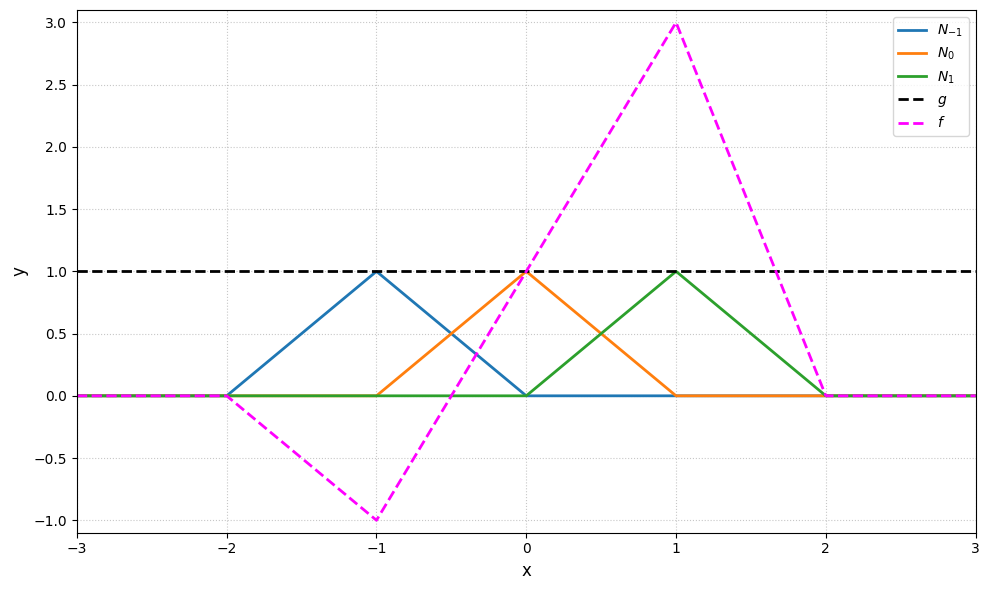

In [ ]:
def N(x, xo):
    return np.maximum(1 - np.abs(x - xo), 0.0)

x = np.linspace(-3.0, 3.0, 1000)
n1 = N(x, -1.0)
n2 = N(x, +0.0)
n3 = N(x, +1.0)
g = np.ones(x.shape)
f = -1 * n1 + 1 * n2 + 3 * n3

plt.figure(figsize=(10, 6))
plt.plot(x, n1, label=r"$N_{-1}$", linewidth=2)
plt.plot(x, n2, label=r"$N_0$", linewidth=2)
plt.plot(x, n3, label=r"$N_1$", linewidth=2)
plt.plot(x, g, label=r"$g$", linewidth=2, linestyle='--', color='black')
plt.plot(x, f, label=r"$f$", linewidth=2, linestyle='--', color='magenta')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(-3, 3)
plt.ylim(-1.1, 3.1)
plt.tight_layout()
plt.show()

In [58]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def bilinear(p):
    x, u_1, u_2, u_3 = sp.symbols('x u_1 u_2 u_3')
    u = 1 + u_1 * x + u_2 * x ** 2 + u_3 * x ** 3
    v = x ** p

    integ1 = (x ** 2 * u - x * u.diff(x)) * v
    integ2 = (1 + x ** 2) * u.diff(x) * v.diff(x)
    a_u_v = (6 * u * v).subs(x, 1) + sp.integrate(integ1, (x, 0, 1)) - sp.integrate(integ2, (x, 0, 1))

    a_u_v_simplified = sp.simplify(a_u_v)

    return a_u_v_simplified

In [42]:
def get_coeffs(expr, u_1, u_2, u_3):
    coeffs = sp.collect(expr, (u_1, u_2, u_3)).as_coefficients_dict()
    return [float(coeffs[u_1]), float(coeffs[u_2]), float(coeffs[u_3]), float(coeffs[1])]

In [71]:
# Obtain analytical expressions
x, u_1, u_2, u_3 = sp.symbols('x u_1 u_2 u_3')
u = 1 + u_1*x + u_2*x**2 + u_3*x**3

print("For v = x:")
a_u_v_collected = sp.collect(bilinear(1), (u_1, u_2, u_3))
sp.pprint(a_u_v_collected)

print("\nFor v = x^2:")
a_u_v_collected = sp.collect(bilinear(2), (u_1, u_2, u_3))
sp.pprint(a_u_v_collected)

print("\nFor v = x^3:")
a_u_v_collected = sp.collect(bilinear(3), (u_1, u_2, u_3))
sp.pprint(a_u_v_collected)

For v = x:
68⋅u₁   25⋅u₂   138⋅u₃   25
───── + ───── + ────── + ──
 15       6       35     4 

For v = x^2:
53⋅u₁   379⋅u₂   25⋅u₃   31
───── + ────── + ───── + ──
 12      105       8     5 

For v = x^3:
152⋅u₁   79⋅u₂   818⋅u₃   37
────── + ───── + ────── + ──
  35      24      315     6 


In [44]:
# Obtain stiffness matrix and load vector
A, b = [], []

for p in range(1, 4):
    coeffs = get_coeffs(bilinear(p), u_1, u_2, u_3)
    A.append(coeffs[0:3])
    b.append(-coeffs[-1])

A, b = np.array(A), np.array(b)

print("Stiffness Matrix:")
print(A)
print("\nLoad Vector:")
print(b)

Stiffness Matrix:
[[4.53333333 4.16666667 3.94285714]
 [4.41666667 3.60952381 3.125     ]
 [4.34285714 3.29166667 2.5968254 ]]

Load Vector:
[-6.25       -6.2        -6.16666667]


In [45]:
# Solve equation
coeffs = np.linalg.inv(A) @ b

print("Coefficients:")
print(coeffs)

Coefficients:
[-1.54357586  0.08132272  0.1036556 ]


In [54]:
# Construct solution
uh = 1 + coeffs[0]*x + coeffs[1]*x**2 + coeffs[2]*x**3
uh = sp.simplify(uh)

print("Solution:")
sp.pprint(uh)

Solution:
                   3                       2                         
0.103655604372297⋅x  + 0.0813227234166564⋅x  - 1.54357586492629⋅x + 1


In [61]:
# Test solution - PDE
R = (1 + x ** 2) * uh.diff(x, 2) + x * uh.diff(x) + x ** 2 * uh - 0.0
print(f"Residual = {R.subs(x, np.random.rand())}")

# Test solution - BC
print(f"u'(1) - 3u(1) = {(uh.diff(x)).subs(x, 1) - 3 * uh.subs(x, 1)}") # u'(1) - 3u(1) = 0
print(f"u(0) = {uh.subs(x, 0)}") # u(0) = 1

Residual = 0.108426026162505
u'(1) - 3u(1) = 0.00582900643593098
u(0) = 1


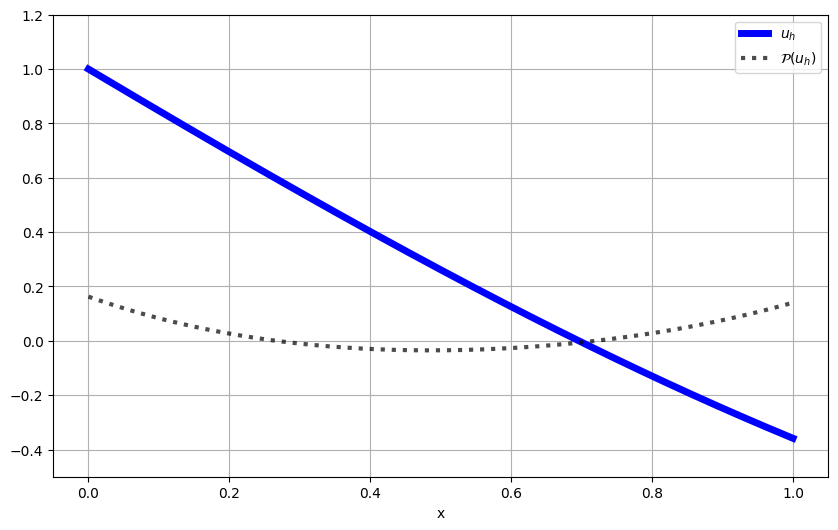

In [75]:
# Plot solution
uh_func = sp.lambdify(x, uh, "numpy")
R_func = sp.lambdify(x, R, "numpy")
x_vals = np.linspace(0, 1, 1000)
uh_vals = uh_func(x_vals)
R_vals = R_func(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, uh_vals, color='blue', linewidth=5, label='$u_h$')
plt.plot(x_vals, R_vals, color='black', linestyle='dotted', linewidth=3, alpha=0.7, label='$\mathcal{P}(u_h)$')
plt.xlabel("x")
plt.grid(True)
plt.legend()
plt.ylim(-0.5, 1.2)
plt.show()